# Structure analysis of human hemoglobin

This notebook provides an example application of different structure-related methods from *Biotite* to a structure of human hemoglobin.
The molecular visualization is performed using *PyMOL*, with *Ammolite* handling the conversion from *Biotite*.

## Macromolecular assembly

The coordinates provided in PDB entries do not necessarily depict the biologically active form of a biomacromolecule.
Instead, at least in the case of X-ray structures, it shows the conformation in the asymmetric unit of a crystal.
PDBx/mmCIF files list the transformations on these coordinates required to create the active form, the macromolecular assembly.

In [1]:
import numpy as np
import matplotlib
import biotite.structure as struc
import biotite.structure.io.pdbx as pdbx
import biotite.database.rcsb as rcsb
import ammolite

matplotlib.rcParams['figure.dpi'] = 80

# Colors at same lightness and similar saturation in L*a*b* color space
COLORS = {
    # L = 50
    "red"         : [219/255,  58/255,  53/255],
    "blue"        : [ 23/255, 114/255, 240/255],
    "green"       : [  8/255, 139/255,   5/255],
    "violet"      : [203/255,  56/255, 170/255],
    "gray"        : [118/255, 118/255, 118/255],
    "orange"      : [247/255, 138/255,  41/255],
    # L = 70
    "lightred"    : [255/255, 138/255, 118/255],
    "lightblue"   : [145/255, 167/255, 255/255],
    "lightgreen"  : [118/255, 188/255,  99/255],
    "lightviolet" : [241/255, 135/255, 211/255],
    "yellow"      : [200/255, 168/255,  67/255],
    "lightgray"   : [171/255, 171/255, 171/255],
}

For comparison with the assembly, the asymmetric unit of the hemoglobin structure (PDB: `6BB5`) is visualized first.

 PyMOL(TM) Molecular Graphics System, Version 2.5.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

 Ray: render time: 2.10 sec. = 1710.7 frames/hour (2.10 sec. accum.).


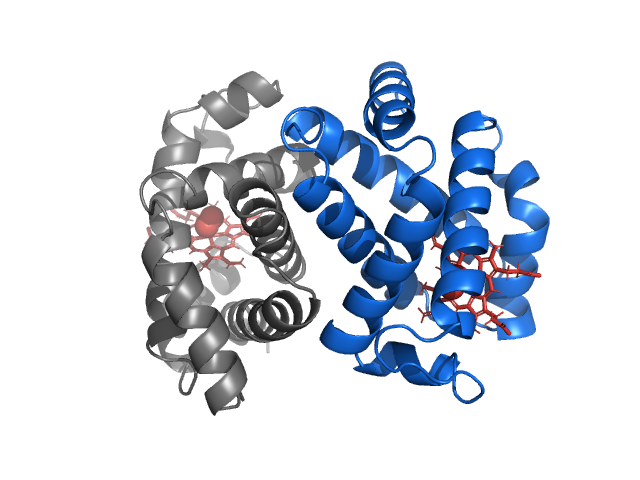

In [2]:
pdbx_file = pdbx.PDBxFile.read(rcsb.fetch("6BB5", "pdbx"))

# Charges are required for docking
asymmetric_unit = pdbx.get_structure(pdbx_file, model=1, extra_fields=["charge"])
asymmetric_unit.bonds = struc.connect_via_residue_names(asymmetric_unit)
asymmetric_unit = asymmetric_unit[~struc.filter_solvent(asymmetric_unit)]

# Visualization of asymmetric unit with PyMOL using Ammolite
ammolite.reset()
pymol_asymmetric = ammolite.PyMOLObject.from_structure(asymmetric_unit)
pymol_asymmetric.color(COLORS["blue"], asymmetric_unit.chain_id == "A")
pymol_asymmetric.color(COLORS["gray"], asymmetric_unit.chain_id == "B")
pymol_asymmetric.color(COLORS["red"], np.isin(asymmetric_unit.res_name, ("HEM", "OXY")))
ammolite.show()

Now the assembly is read from the PDBx file to obtain the functional unit of hemoglobin:
a heterotetramer containing two copies of each, the $\alpha$ and $\beta$ subunits.

 Ray: render time: 3.14 sec. = 1146.0 frames/hour (5.25 sec. accum.).


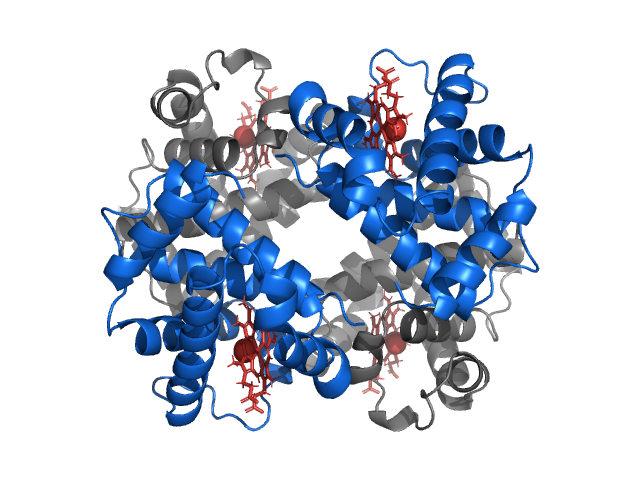

In [3]:
assembly = pdbx.get_assembly(pdbx_file, model=1)
assembly.bonds = struc.connect_via_residue_names(assembly)
assembly = assembly[~struc.filter_solvent(assembly)]

ammolite.reset()
pymol_assembly = ammolite.PyMOLObject.from_structure(assembly)
pymol_assembly.color(COLORS["blue"], assembly.chain_id == "A")
pymol_assembly.color(COLORS["gray"], assembly.chain_id == "B")
# Color heme group and bound oxgen red
pymol_assembly.color(COLORS["red"], np.isin(assembly.res_name, ("HEM", "OXY")))
pymol_assembly.orient()
ammolite.show()

## Elastic network model

Using an anisotropic network model, the normal modes of the assembly are computed.
The first mode, i.e. the predicted mode with highest amplitude, is depicted by arrows.

 Ray: render time: 3.76 sec. = 957.0 frames/hour (9.01 sec. accum.).


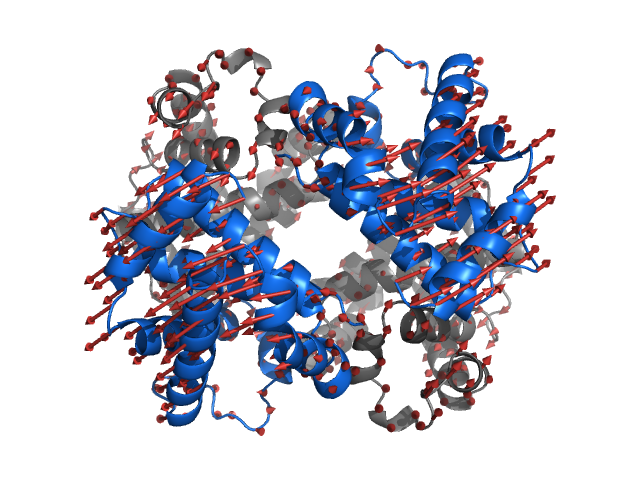

In [4]:
import springcraft

MODE = 0
MAX_AMPLITUDE = 8

assembly_ca = assembly[struc.filter_amino_acids(assembly) & (assembly.atom_name == "CA")]
ff = springcraft.TabulatedForceField.sd_enm(assembly_ca)
anm = springcraft.ANM(assembly_ca, ff)
_, eigen_vectors = anm.eigen()
# Remove translation/rotation modes
eigen_vectors = eigen_vectors[6:]


ammolite.reset()

pymol_object = ammolite.PyMOLObject.from_structure(assembly)
pymol_object.color(COLORS["blue"],  assembly.chain_id == "A")
pymol_object.color(COLORS["gray"], assembly.chain_id == "B")
# Remove heme group for clarity
mask = np.isin(assembly.res_name, ("HEM", "OXY"))
pymol_object.hide("sticks", mask)
pymol_object.hide("spheres", mask)

# Show chosen mode as arrows
vector = eigen_vectors[MODE].reshape(-1, 3)
vector /= np.max(vector)
vector *= MAX_AMPLITUDE
ammolite.draw_arrows(
    assembly_ca.coord, assembly_ca.coord + vector,
    radius=0.25, head_radius=0.6, head_length=1.5,
    color=COLORS["red"]
)
pymol_object.orient()
ammolite.show()

## Molecular docking

With the help of *AutoDock Vina* the binding conformation of the heme group should be predicted by molecular docking.
In the case of the protein structure at hand, heme is resolved.
However, the docking protocol can be easily adapted to other proteins, where to position of the ligand is unknown.

In [5]:
import matplotlib.pyplot as plt
import biotite.application.autodock as autodock
import biotite.structure.info as info

DOCK_RADIUS = 20

For the docking procedure the $\alpha$ chain is extracted from the structure as later docking target.
The heme position is also saved for later comparison purposes.
As ligand a new heme molecule is obtained from the [Chemical component dictionary](https://www.wwpdb.org/data/ccd).
The ligand is then docked to the target protein chain in vicinity of the heme binding pocket.
*Vina* creates multiple docking poses, each one associated with a predicted binding energy.

In [6]:
###
# The docking protocol was adapted from
# https://www.biotite-python.org/examples/gallery/structure/docking.html
# (Code source: Patrick Kunzmann, License: BSD 3 clause)
###

alpha_subunit = asymmetric_unit[
    struc.filter_amino_acids(asymmetric_unit) &
    (asymmetric_unit.chain_id == "A")
]
ref_heme = asymmetric_unit[
    (asymmetric_unit.res_name == "HEM") &
    (asymmetric_unit.chain_id == "A") &
    # Remove hydrogen atoms for comparison with docked heme
    (asymmetric_unit.element != "H")
]


# Independently, get the ligand without optimized conformation
# from the Chemical Component Dictionary
heme = info.residue("HEM")

# Search for a binding mode in vicinity of heme binding pocket
app = autodock.VinaApp(
    heme, alpha_subunit, struc.centroid(ref_heme),
    [DOCK_RADIUS, DOCK_RADIUS, DOCK_RADIUS]
)
# For reproducibility
app.set_seed(0)
# This is the maximum number:
# Vina may find less interesting binding modes
# and thus output less models
app.set_max_number_of_models(100)
# Effectively no limit
app.set_energy_range(100.0)
# Start docking run
app.start()
app.join()
# The calcuated heme atom coordinates and binding energy
# for each found potential binding pose
docked_coord = app.get_ligand_coord()
energies = app.get_energies()

/home/kunzmann/data/coding/biotite/src/biotite/structure/io/pdbqt/file.py:359: UserWarning: Parameters required for computation of electronegativity aren't available for the following atoms: FE. Their electronegativity is given as NaN.
  charges = partial_charges(atoms)


Now the obtained binding poses are evaluated.
The most likely conformation is the one with the lowest binding energy.
As the X-ray structure of hemoglobin comes with the '*correct*' heme binding position,
it can be used as reference to assess the docking accuracy.
For this purpose the RMSD between the docked and reference atom positions is calculated for each binding pose.
As a result, the binding pose with the lowest predicted binding energy is indeed the conformation that is closest
to the experimentally determined one.

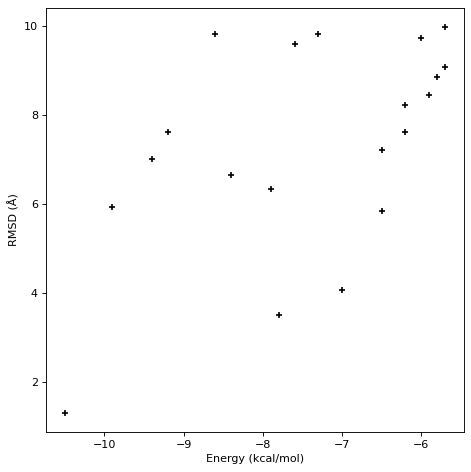

In [7]:
# Create an AtomArrayStack for all docked binding poses
docked_heme = struc.from_template(heme, docked_coord)
# Vina discards all nonpolar hydrogen atoms,
# and polar hydrogen atoms get arbitrary orientations
# -> Remove hydrogen atoms
docked_heme = docked_heme[
    ..., docked_heme.element != "H"
]

# Standardize atom order, so that docked atoms
# are correctly mapped to reference atoms for comparison
docked_heme = docked_heme[..., info.standardize_order(docked_heme)]
ref_heme = ref_heme[info.standardize_order(ref_heme)]

# Calculate the RMSD of the docked models to the correct binding mode
# No superimposition prior to RMSD calculation, as we want to see
# conformation differences with respect to the binding pocket
rmsd = struc.rmsd(ref_heme, docked_heme)

figure, ax = plt.subplots(figsize=(6.0, 6.0))
ax.scatter(energies, rmsd, marker="+", color="black")
ax.set_xlabel("Energy (kcal/mol)")
ax.set_ylabel("RMSD (Å)")
figure.tight_layout()
plt.show()

Visual analysis of this docking pose in comparison with the experimentally found coordinates underpins its correctness.

 Ray: render time: 0.41 sec. = 8724.3 frames/hour (9.42 sec. accum.).


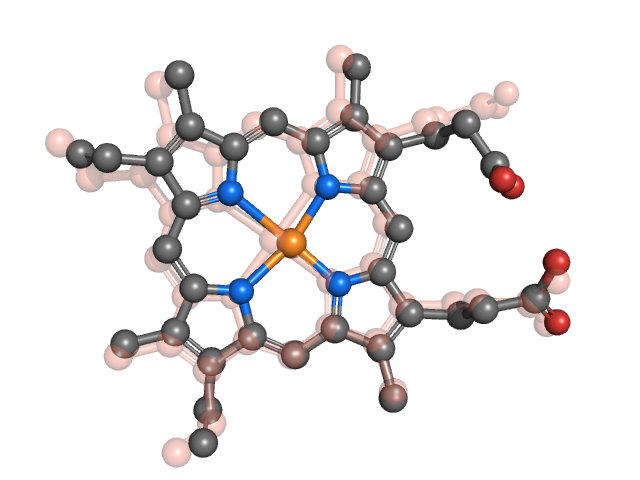

In [8]:
best_pose = docked_heme[np.argmin(energies)]

ammolite.reset()
pymol_ref_heme = ammolite.PyMOLObject.from_structure(ref_heme)
pymol_docked_heme = ammolite.PyMOLObject.from_structure(best_pose)

# Visualize as ball-and-stick model
ammolite.cmd.set("stick_radius", 0.15)
ammolite.cmd.set("sphere_scale", 0.25)
ammolite.cmd.set("sphere_quality", 4)

# The reference is a red 'shadow'
REF_COLOR = COLORS["lightred"]
REF_ALPHA = 0.4
pymol_ref_heme.show("spheres")
pymol_ref_heme.color(REF_COLOR)
# Register color for usage in 'set' command
ammolite.cmd.set_color("custom_red", REF_COLOR)
pymol_ref_heme.set("stick_color", "custom_red")
pymol_ref_heme.set("sphere_transparency", 1 - REF_ALPHA)
pymol_ref_heme.set_bond("stick_transparency", 1 - REF_ALPHA)

pymol_docked_heme.show("spheres")
pymol_docked_heme.color(COLORS["gray"], docked_heme.element == "C")
pymol_docked_heme.color(COLORS["red"], docked_heme.element == "O")
pymol_docked_heme.color(COLORS["blue"], docked_heme.element == "N")
pymol_docked_heme.color(COLORS["orange"], docked_heme.element == "FE")

# Adjust camera
pymol_docked_heme.orient()
pymol_docked_heme.zoom(buffer=1)
ammolite.cmd.set("depth_cue", 0)

ammolite.show()

## Hydrogen bond indentification

To determine hydrogen bonds between the docked heme group and the $\alpha$ subunit, hydrogen atoms need to be added
to the ligand, as *Vina* uses only heavy atoms to find optimal binding poses.
For this task the *Hydride* package is used.
As the X-ray structure has resolved hydrogen atoms, this does not need to be done for the $\alpha$ subunit.

In [9]:
import hydride


# Indicate deprotonated form in carboxy groups by setting a negtive charge
best_pose.charge[np.isin(best_pose.atom_name, ["O2A", "O2D"])] = -1

# Concatenate unbound hemoglobin alpha subunit
# with found binding pose of heme to form a complex
bound_subunit_alpha = alpha_subunit + best_pose

# The peptide chain already has hydrogen atoms
# -> Only attach and relax hydrogen atoms in heme group,
# since these are missing after docking
bound_subunit_alpha, _ = hydride.add_hydrogen(
    bound_subunit_alpha, mask=bound_subunit_alpha.res_name == "HEM"
)
bound_subunit_alpha.coord = hydride.relax_hydrogen(
    bound_subunit_alpha, mask=bound_subunit_alpha.res_name == "HEM"
)

/tmp/ipykernel_13521/1824862370.py:17: UserWarning: Parameters required for computation of electronegativity aren't available for the following atoms: FE. Their electronegativity is given as NaN.
  bound_subunit_alpha.coord = hydride.relax_hydrogen(


After hydrogen addition the hydrogen bonds are measured and visualized.

 Ray: render time: 0.16 sec. = 22106.1 frames/hour (9.58 sec. accum.).


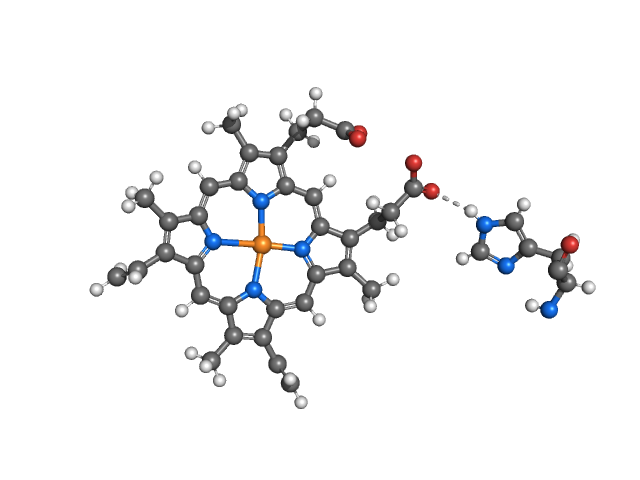

In [10]:
# Only search after hydrogen bond between protein and heme
donor_indices, donor_h_indices, acceptor_indices = struc.hbond(
    bound_subunit_alpha,
    selection1=struc.filter_amino_acids(bound_subunit_alpha),
    selection2=bound_subunit_alpha.res_name == "HEM"
).T
# Find residues by ID of atoms forming hydrogen bonds
binding_res_ids = np.concatenate([
    bound_subunit_alpha.res_id[indices]
    for indices in (donor_indices, acceptor_indices)
])

binding_pocket_mask = (
    (bound_subunit_alpha.res_name == "HEM") |
    np.isin(bound_subunit_alpha.res_id, binding_res_ids)
)


ammolite.reset()

ammolite.cmd.set("stick_radius", 0.15)
ammolite.cmd.set("sphere_scale", 0.25)
ammolite.cmd.set("sphere_quality", 4)

pymol_complex = ammolite.PyMOLObject.from_structure(bound_subunit_alpha)
pymol_complex.show_as("sticks")
pymol_complex.show("spheres")
pymol_complex.hide("sticks", ~binding_pocket_mask)
pymol_complex.hide("spheres", ~binding_pocket_mask)
pymol_complex.color(COLORS["gray"], bound_subunit_alpha.element == "C")
pymol_complex.color(COLORS["red"], bound_subunit_alpha.element == "O")
pymol_complex.color(COLORS["blue"], bound_subunit_alpha.element == "N")
pymol_complex.color(COLORS["orange"], bound_subunit_alpha.element == "FE")

# Show hydrogen bonds as dashed lines
for i, j in zip(donor_h_indices, acceptor_indices):
    pymol_complex.distance(f"bond_{i}_{j}", i, j, show_label=False)
ammolite.cmd.set("dash_color", "grey80")

ammolite.cmd.set("depth_cue", 0)
pymol_complex.orient(binding_pocket_mask)
ammolite.show()